In [1]:
# Importa la biblioteca pandas, utilizada para manipular y analizar datos estructurados como tablas (dataframes).
import pandas as pd

# Importa la biblioteca re, que se usa para trabajar con expresiones regulares (útil para manipular y analizar texto).
import re

# Importa herramientas específicas de la biblioteca transformers de Hugging Face:
# - BertTokenizer: Tokenizador preentrenado para el modelo BERT, convierte texto en entradas numéricas.
# - BertForSequenceClassification: Modelo BERT preentrenado adaptado para tareas de clasificación de secuencias.
# - Trainer y TrainingArguments: Herramientas para configurar y ejecutar el proceso de entrenamiento de modelos.
# - EarlyStoppingCallback: Callback para detener el entrenamiento si no mejora después de ciertos pasos.
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback, AutoTokenizer, AutoModelForSequenceClassification, pipeline, EarlyStoppingCallback, RobertaTokenizer, RobertaForSequenceClassification

# Importa PyTorch, una biblioteca de Machine Learning que se utiliza para definir y entrenar redes neuronales.
import torch

# Importa train_test_split de scikit-learn, usado para dividir un conjunto de datos en subconjuntos de entrenamiento y prueba.
from sklearn.model_selection import train_test_split

# Importa DataLoader y Dataset de PyTorch, que se usan para manejar y cargar datos en lotes durante el entrenamiento.
from torch.utils.data import DataLoader, Dataset

# Importa classification_report de scikit-learn, que genera un informe con métricas de evaluación como precisión, recuperación y F1.
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, average_precision_score, accuracy_score, precision_recall_fscore_support, precision_score, recall_score

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Definimos la ruta base del proyecto.
path = ''

# Definimos los nombres de las columnas clave del dataset:
COLUMN_ID = 'id'               # Identificador único para cada muestra
COLUMN_LETRA = 'lyrics'       # Columna con la letra de la canción
COLUMN_ETIQUETA = 'label'     # Etiqueta de clase (0 = No Misógina, 1 = Misógina)
COLUMN_RAZONAMIENTO = 'reasoning'  # Columna con el razonamiento explicativo (Chain of Thought)


In [ ]:
from sklearn.utils import resample

# Cargamos el dataset con razonamientos generados por GPT-4o
dfTotal = pd.read_csv(f'{path}/../data/train_data/task1_GPT4o_dataReasoning.csv')

# Dividimos el dataset original en entrenamiento y test (80% - 20%) de forma estratificada
train_df_temp, test_df = train_test_split(
    dfTotal,
    test_size=0.2,
    random_state=42,
    stratify=dfTotal[COLUMN_ETIQUETA]
)

# A partir del conjunto de entrenamiento temporal, extraemos validación (20% de train) también estratificado
train_df, valid_df = train_test_split(
    train_df_temp,
    test_size=0.2,
    random_state=42,
    stratify=train_df_temp[COLUMN_ETIQUETA]
)

# Mostramos la distribución de clases en cada subconjunto antes de aplicar balanceo
print("\n--- Distribución de Clases ---")
print("Conjunto de Entrenamiento:")
print(train_df[COLUMN_ETIQUETA].value_counts(normalize=False))

print("\nConjunto de Validación:")
print(valid_df[COLUMN_ETIQUETA].value_counts(normalize=False))

print("\nConjunto de Test:")
print(test_df[COLUMN_ETIQUETA].value_counts(normalize=False))
print("-----------------------------")

# Separamos las clases en el conjunto de entrenamiento para aplicar oversampling
majority_class_df = train_df[train_df[COLUMN_ETIQUETA] == 0]
minority_class_df = train_df[train_df[COLUMN_ETIQUETA] == 1]

# Aplicamos oversampling a la clase minoritaria para mejorar el balance de clases
minority_oversampled_df = resample(
    minority_class_df,
    replace=True,        # Permitimos duplicados
    n_samples=600,       # Tamaño fijo para clase minoritaria (aprox. 60-40%)
    # n_samples=len(majority_class_df),  # Alternativa: igualar tamaños de ambas clases
    random_state=42
)

# Combinamos el conjunto mayoritario original con la versión sobremuestreada del minoritario
train_df_balanced = pd.concat([majority_class_df, minority_oversampled_df])

# Mostramos la nueva distribución tras el balanceo
print("\nConjunto de Entrenamiento Nuevo:")
print(train_df_balanced[COLUMN_ETIQUETA].value_counts(normalize=False))
print("-----------------------------")

# Barajamos el conjunto para evitar que las clases queden agrupadas
train_df_balanced = train_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


--- Distribución de Clases ---
Conjunto de Entrenamiento:
label
0    935
1    411
Name: count, dtype: int64

Conjunto de Validación:
label
0    234
1    103
Name: count, dtype: int64

Conjunto de Test:
label
0    293
1    128
Name: count, dtype: int64
-----------------------------

Conjunto de Entrenamiento Nuevo:
label
0    935
1    600
Name: count, dtype: int64
-----------------------------


In [ ]:
from datasets import Dataset

# Convertimos los DataFrames de pandas a objetos Dataset de Hugging Face.
# Esto es necesario para usarlos con modelos y entrenadores de la librería transformers.

train_data = Dataset.from_pandas(train_df_balanced)  # Dataset de entrenamiento balanceado
valid_data = Dataset.from_pandas(valid_df)           # Dataset de validación (sin modificar)
test_data = Dataset.from_pandas(test_df)             # Dataset de test (sin modificar)

In [ ]:
from transformers import LongformerTokenizer

# Cargamos el tokenizador de Longformer entrenado con BETO en español
# Este modelo permite entradas largas (hasta 4096 tokens) y es útil para procesar letras extensas
tokenizer = AutoTokenizer.from_pretrained('PlanTL-GOB-ES/longformer-base-4096-bne-es')

# Definimos una función para tokenizar cada ejemplo del dataset
def tokenizeFunction(example):
    tokens = tokenizer(
        example[COLUMN_LETRA],       # Tokenizamos la letra de la canción
        padding="max_length",        # Añadimos padding hasta la longitud máxima
        truncation=True,             # Truncamos si la entrada es más larga de lo permitido
        max_length=1024              # Limitamos a 1024 tokens (aunque el modelo permite hasta 4096)
    )
    
    # Longformer requiere una máscara de atención global.
    # Aquí activamos atención global solo en el primer token
    tokens["global_attention_mask"] = [0] * len(tokens["input_ids"])
    tokens["global_attention_mask"][0] = 1
    
    return tokens

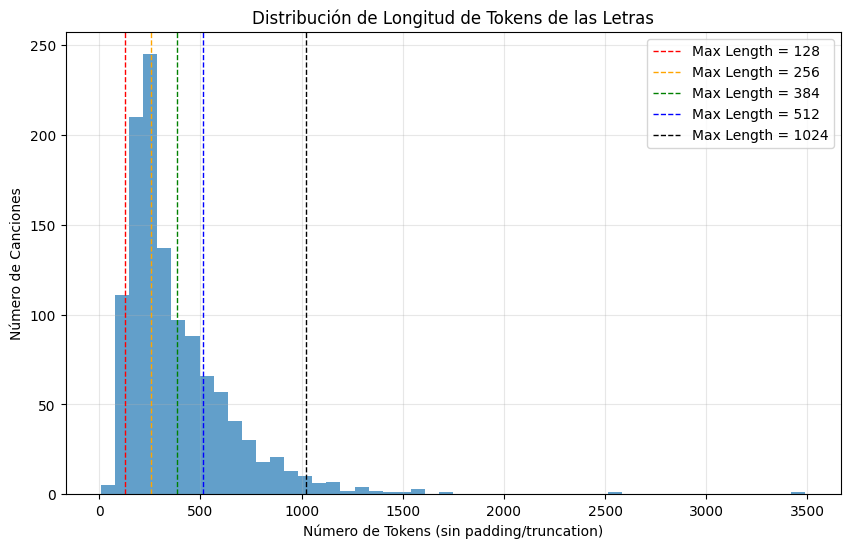

Porcentaje de canciones con más de 128 tokens: 94.40%
Porcentaje de canciones con más de 256 tokens: 59.42%
Porcentaje de canciones con más de 384 tokens: 36.25%
Porcentaje de canciones con más de 512 tokens: 23.26%
Porcentaje de canciones con más de 1024 tokens: 2.80%


In [ ]:
# --- Análisis exploratorio: distribución de longitud de las letras tokenizadas ---

import matplotlib.pyplot as plt

# Calculamos la longitud (número de tokens) de cada letra en el conjunto de entrenamiento
# No añadimos tokens especiales aún, solo los tokens reales de contenido
token_lengths = [len(tokenizer.encode(text, add_special_tokens=False)) for text in train_df[COLUMN_LETRA].astype(str)]

# Creamos un histograma para visualizar la distribución de longitudes
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=50, alpha=0.7)

# Añadimos líneas verticales de referencia para longitudes típicas
plt.axvline(128, color='red', linestyle='dashed', linewidth=1, label='Max Length = 128')
plt.axvline(256, color='orange', linestyle='dashed', linewidth=1, label='Max Length = 256')
plt.axvline(384, color='green', linestyle='dashed', linewidth=1, label='Max Length = 384')
plt.axvline(512, color='blue', linestyle='dashed', linewidth=1, label='Max Length = 512')
plt.axvline(1024, color='black', linestyle='dashed', linewidth=1, label='Max Length = 1024')

# Añadimos etiquetas y leyenda al gráfico
plt.xlabel('Número de Tokens (sin padding/truncation)')
plt.ylabel('Número de Canciones')
plt.title('Distribución de Longitud de Tokens de las Letras')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Imprimimos estadísticas de interés: porcentaje de letras que superan ciertas longitudes
print(f"Porcentaje de canciones con más de 128 tokens: {sum(l > 128 for l in token_lengths) / len(token_lengths) * 100:.2f}%")
print(f"Porcentaje de canciones con más de 256 tokens: {sum(l > 256 for l in token_lengths) / len(token_lengths) * 100:.2f}%")
print(f"Porcentaje de canciones con más de 384 tokens: {sum(l > 384 for l in token_lengths) / len(token_lengths) * 100:.2f}%")
print(f"Porcentaje de canciones con más de 512 tokens: {sum(l > 512 for l in token_lengths) / len(token_lengths) * 100:.2f}%")
print(f"Porcentaje de canciones con más de 1024 tokens: {sum(l > 1024 for l in token_lengths) / len(token_lengths) * 100:.2f}%")

In [ ]:
# Aplicamos la función de tokenización al conjunto de entrenamiento, validación y test.
# Esto añade los campos necesarios para entrenar con Hugging Face (input_ids, attention_mask, etc.).
train_data_tokenized = train_data.map(tokenizeFunction)
valid_data_tokenized = valid_data.map(tokenizeFunction)
test_data_tokenized = test_data.map(tokenizeFunction)

# Definimos una función auxiliar para renombrar el campo "label" como "labels",
# que es el nombre esperado por los modelos de clasificación de transformers.
def fix_labels(example):
    example["labels"] = int(example["label"])  # Aseguramos que la etiqueta sea tipo int
    return example

# Aplicamos esta corrección a los datasets tokenizados
train_data_tokenized = train_data_tokenized.map(fix_labels)
valid_data_tokenized = valid_data_tokenized.map(fix_labels)
test_data_tokenized = test_data_tokenized.map(fix_labels)

Map:   0%|          | 0/1535 [00:00<?, ? examples/s]

Map:   0%|          | 0/337 [00:00<?, ? examples/s]

Map:   0%|          | 0/421 [00:00<?, ? examples/s]

Map:   0%|          | 0/1535 [00:00<?, ? examples/s]

Map:   0%|          | 0/337 [00:00<?, ? examples/s]

Map:   0%|          | 0/421 [00:00<?, ? examples/s]

In [ ]:
# Indicamos que queremos trabajar con tensores de PyTorch en lugar de listas de Python.
# Esto es necesario para poder entrenar con `Trainer` y modelos de Hugging Face sin errores.

train_data_tokenized = train_data_tokenized.with_format(
    "torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"]
)

valid_data_tokenized = valid_data_tokenized.with_format(
    "torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"]
)

test_data_tokenized = test_data_tokenized.with_format(
    "torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"]
)

In [ ]:
from transformers import AutoModelForSequenceClassification, LongformerForSequenceClassification
from transformers import AutoTokenizer, FillMaskPipeline

# Cargamos el modelo Longformer previamente entrenado por PlanTL-GOB-ES para español,
# adaptado a una tarea de clasificación de secuencias.
# Especificamos que hay 2 etiquetas (misógina = 1, no misógina = 0).

model = AutoModelForSequenceClassification.from_pretrained(
    'PlanTL-GOB-ES/longformer-base-4096-bne-es',
    num_labels=2
)


Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/longformer-base-4096-bne-es and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Reducimos el tamaño del conjunto de entrenamiento y validación para pruebas rápidas.
# Esto es útil para verificar que todo el flujo de entrenamiento funciona antes de lanzarlo completo.

train_data_tokenized = train_data_tokenized.select(range(20))  # Usamos solo los primeros 20 ejemplos de entrenamiento
valid_data_tokenized = valid_data_tokenized.select(range(10))  # Usamos solo los primeros 10 ejemplos de validación

In [ ]:
from transformers import TrainingArguments

# Definimos los argumentos de entrenamiento que usará el Trainer de Hugging Face

trainingArgs = TrainingArguments(
    output_dir='outputs',                 # Carpeta donde se guardarán los modelos y checkpoints
    num_train_epochs=5,                  # Número total de épocas de entrenamiento
    per_device_train_batch_size=2,       # Tamaño del batch de entrenamiento por GPU/CPU
    per_device_eval_batch_size=4,        # Tamaño del batch de evaluación (más grande ya que no hay retropropagación)
    gradient_accumulation_steps=8,       # Acumulamos gradientes para simular batch_size efectivo de 16
    learning_rate=2e-05,                 # Tasa de aprendizaje inicial
    weight_decay=0.01,                   # Penalización L2 para evitar overfitting
    eval_strategy="epoch",               # Evaluamos automáticamente al final de cada época
    logging_dir='logs',                  # Carpeta donde guardar los logs
    load_best_model_at_end=True,         # Recuperamos el mejor modelo según eval_loss al final
    metric_for_best_model='eval_loss',   # Usamos eval_loss como métrica principal
    save_strategy='epoch'                # Guardamos el modelo al final de cada época
)

In [ ]:
from transformers import Trainer, EarlyStoppingCallback

# Inicializamos el Trainer, que se encargará de todo el proceso de entrenamiento y evaluación

trainer = Trainer(
    model=model,                               # Modelo de clasificación cargado (Longformer)
    args=trainingArgs,                         # Argumentos definidos previamente
    train_dataset=train_data_tokenized,        # Dataset de entrenamiento tokenizado
    eval_dataset=valid_data_tokenized,         # Dataset de validación tokenizado

    # Añadimos EarlyStopping para detener el entrenamiento si no mejora durante 3 evaluaciones consecutivas
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
# Ejecutar el entrenamiento
trainer.train()

# Evaluar el modelo
trainer.evaluate()

Epoch,Training Loss,Validation Loss


In [ ]:
# Guardamos el modelo fine-tuneado en la ruta especificada.
# Esto incluye tanto los pesos como la configuración necesaria para volver a cargarlo después.

trainer.save_model(f'{path}/models/LongformerBaseline')

In [ ]:
# Redefinimos la función de tokenización en caso de que se haya sobrescrito o necesitemos reutilizarla.
# Esta función:
# - Tokeniza la letra de la canción
# - Aplica padding y truncamiento hasta 1024 tokens
# - Añade la máscara de atención global para Longformer (activando solo el primer token)

def tokenizeFunction(example):
    tokens = tokenizer(
        example[COLUMN_LETRA],  # Utilizamos la columna que contiene las letras de las canciones
        padding="max_length",
        truncation=True,
        max_length=1024
    )
    tokens["global_attention_mask"] = [0] * len(tokens["input_ids"])
    tokens["global_attention_mask"][0] = 1
    return tokens

# Aplicamos nuevamente la tokenización al conjunto de test, por si se modificó o cargó sin procesar
test_data = test_data.map(tokenizeFunction, batched=False)

Map:   0%|          | 0/421 [00:00<?, ? examples/s]

C:\Users\Antonio\AppData\Local\Temp\ipykernel_28508\2798892976.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Map:   0%|          | 0/421 [00:00<?, ? examples/s]

Precision: 0.7231
Recall:    0.7344
F1-score:  0.7287


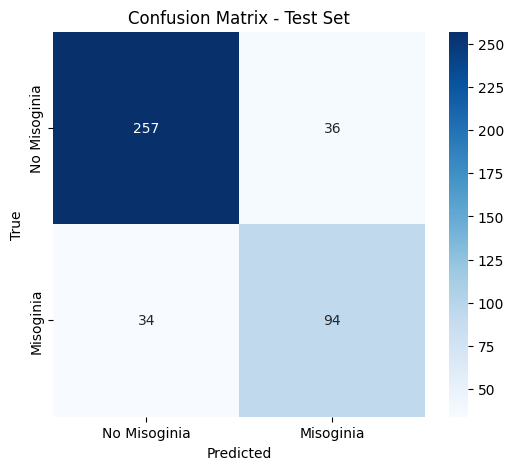

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ruta donde guardaste el modelo previamente fine-tuneado
model_path = f'{path}/models/Model_Longformer_SINCOT_LR_2e-5-Tarea_1'

# Cargamos el modelo desde el directorio local donde fue guardado
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Cargamos nuevamente el tokenizador (puede usarse directamente desde Hugging Face o desde tu ruta local si lo guardaste)
tokenizer = AutoTokenizer.from_pretrained('PlanTL-GOB-ES/longformer-base-4096-bne-es')

# Creamos una nueva instancia de Trainer solo para hacer predicción
trainer = Trainer(
    model=model,
    tokenizer=tokenizer
)

# Definimos la función de tokenización (por si aún no se había aplicado al test_data)
def tokenizeFunction(example):
    tokens = tokenizer(
        example['lyrics'],           # Tokenizamos la letra
        padding="max_length",
        truncation=True,
        max_length=1024
    )
    tokens["global_attention_mask"] = [0] * len(tokens["input_ids"])
    tokens["global_attention_mask"][0] = 1
    return tokens

# Aplicamos tokenización al test set
test_data = test_data.map(tokenizeFunction)

# Hacemos la predicción usando el Trainer
predictions = trainer.predict(test_data)

# Obtenemos la etiqueta predicha (argmax sobre logits)
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Extraemos las etiquetas verdaderas desde el dataset
true_labels = np.array(test_data['label'])

# Cálculo de métricas principales
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Mostramos resultados
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

# Matriz de confusión
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Misoginia", "Misoginia"],
    yticklabels=["No Misoginia", "Misoginia"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.show()